# S11 Calibration Verification

**Part 1 — Step 3 of the LibreVNA validation assignment.**

## Objective
Perform a single-port S11 return-loss sweep across the 2.4 GHz Wi-Fi band
with a known 50 Ω termination load connected to Port 1.  A properly
calibrated VNA should see the termination as a near-perfect match, producing
deep return loss across the entire swept band.

## Measurement parameters
| Parameter | Value |
|---|---|
| Frequency range | 2.430 – 2.450 GHz |
| Number of points | 300 |
| IF bandwidth | 50 kHz |
| DUT | 50 Ω termination load on Port 1 |

## Pass criterion
S11 return loss **> 30 dB** at every frequency point
(equivalently, S11 magnitude **< −30 dB** everywhere).

## Notebook workflow
1. **Cell 2** – imports and path setup
2. **Cell 3** – load SOLT calibration into the GUI via `VNA:CALibration:LOAD?`, then run a live sweep via LibreVNA SCPI (requires hardware + GUI)
3. **Cell 4** – *alternative*: load a previously saved CSV instead of Cell 3
4. **Cell 5** – S11 magnitude plot
5. **Cell 6** – automated PASS / FAIL verdict

In [1]:
# ---------------------------------------------------------------------------
# Cell 2  --  Imports and path setup
# ---------------------------------------------------------------------------
import sys
import os
import glob

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# ---------------------------------------------------------------------------
# Absolute paths -- every path in this notebook is fully qualified so that
# the notebook produces the same result regardless of the working directory
# that Jupyter happened to start in.
# ---------------------------------------------------------------------------
SCRIPTS_DIR = (
    "/home/user/jeffrymahbuubi/PROJECTS/"
    "7-LibreVNA-Vector-Network-Analyzer/code/LibreVNA-dev/scripts"
)
DATA_DIR = (
    "/home/user/jeffrymahbuubi/PROJECTS/"
    "7-LibreVNA-Vector-Network-Analyzer/code/LibreVNA-dev/data"
)

# Make the sweep script importable from the notebook.
sys.path.insert(0, SCRIPTS_DIR)

# Guarantee the data directory exists so that save_csv() will not fail.
os.makedirs(DATA_DIR, exist_ok=True)

print(f"SCRIPTS_DIR : {SCRIPTS_DIR}")
print(f"DATA_DIR    : {DATA_DIR}")
print(f"numpy       : {np.__version__}")
print(f"matplotlib  : {plt.matplotlib.__version__}")
print(f"pandas      : {pd.__version__}")

SCRIPTS_DIR : /home/user/jeffrymahbuubi/PROJECTS/7-LibreVNA-Vector-Network-Analyzer/code/LibreVNA-dev/scripts
DATA_DIR    : /home/user/jeffrymahbuubi/PROJECTS/7-LibreVNA-Vector-Network-Analyzer/code/LibreVNA-dev/data
numpy       : 2.2.6
matplotlib  : 3.10.8
pandas      : 2.3.3


In [2]:
# ---------------------------------------------------------------------------
# Cell 3  --  Live S11 sweep  (hardware path)
# ---------------------------------------------------------------------------
# Requires LibreVNA-GUI running with the SCPI server enabled on port 1234.
# If you have already captured a CSV in a previous run, skip this cell and
# execute Cell 4 instead.
# ---------------------------------------------------------------------------

import importlib

# The sweep script's filename starts with a digit, which makes it an illegal
# Python identifier.  importlib.import_module() is the standard workaround;
# SCRIPTS_DIR was already added to sys.path in Cell 2.
_sweep_mod         = importlib.import_module("2_s11_cal_verification_sweep")
connect_and_verify = _sweep_mod.connect_and_verify
load_calibration   = _sweep_mod.load_calibration
run_s11_sweep      = _sweep_mod.run_s11_sweep
save_csv           = _sweep_mod.save_csv

# 1.  Open a connection and run the built-in sanity checks.
vna = connect_and_verify()

# 1b. Load the SOLT calibration file into LibreVNA-GUI via SCPI
#     (VNA:CALibration:LOAD?) so that the sweep below reflects the
#     calibrated reference plane.
load_calibration(vna)

# 2.  Execute the sweep.  Returns Python lists of the same length.
#     freq_hz : list[float]  --  frequency points in Hz
#     s11_db  : list[float]  --  S11 magnitude at each point in dB
freq_hz, s11_db = run_s11_sweep(vna)

# 3.  Persist to CSV so the plot cell can be re-run without hardware.
csv_path = save_csv(freq_hz, s11_db, output_dir=DATA_DIR)
print(f"Sweep saved to : {csv_path}")
print(f"Points captured: {len(freq_hz)}")


  DEVICE CONNECTION
  TCP connection  : OK  (localhost:1234)

  --- *IDN? identification ---
  Raw response    : LibreVNA,LibreVNA-GUI,206830535532,1.6.4
    Manufacturer          : LibreVNA
    Model                 : LibreVNA-GUI
    Serial (IDN)          : 206830535532
    SW Version            : 1.6.4

  --- DEVice:CONNect? -- device serial ---
  Live serial     : 206830535532

  CALIBRATION LOADING
  Cal file path   : /home/user/jeffrymahbuubi/PROJECTS/7-LibreVNA-Vector-Network-Analyzer/code/LibreVNA-dev/calibration/SOLT_1_2_43G-2_45G_300pt.cal
  File exists     : YES
  LOAD? response  : TRUE
  Active cal type : SOLT_1

  SWEEP CONFIGURATION
  Mode            : VNA
  Sweep type      : FREQUENCY
  Stimulus level  : -10 dBm
  IF bandwidth    : 50000 Hz  (50.0 kHz)
  Averaging       : 1 sweep(s)
  Points          : 300
  Frequency range : 2430000000 Hz  --  2450000000 Hz  (2.430 - 2.450 GHz)

  --- Waiting for sweep completion ---
  Sweep finished  : 0.18 s

  --- Reading S11 trace 

In [3]:
# ---------------------------------------------------------------------------
# Cell 4  --  Load data from the most-recent CSV  (offline path)
# ---------------------------------------------------------------------------
# Run this cell INSTEAD OF Cell 3 when the sweep has already been saved to
# disk.  It finds the newest s11_sweep_<YYYYMMDD_HHMMSS>.csv in DATA_DIR
# and loads both columns into numpy arrays.
# ---------------------------------------------------------------------------

csv_candidates = sorted(
    glob.glob(os.path.join(DATA_DIR, "s11_sweep_*.csv"))
)

if not csv_candidates:
    raise FileNotFoundError(
        f"No s11_sweep_*.csv files found in {DATA_DIR}.\n"
        "Run Cell 3 first to perform a live sweep, or copy a CSV into that directory."
    )

# The timestamp-based naming convention means lexicographic sort == chronological.
latest_csv = csv_candidates[-1]
df = pd.read_csv(latest_csv)

freq_hz = df["Frequency_Hz"].to_numpy(dtype=np.float64)
s11_db  = df["S11_dB"].to_numpy(dtype=np.float64)

print(f"Loaded : {os.path.basename(latest_csv)}")
print(f"Points : {len(freq_hz)}")
print(f"Freq   : {freq_hz[0]/1e9:.4f} GHz  --  {freq_hz[-1]/1e9:.4f} GHz")
print(f"S11 min: {s11_db.min():.2f} dB    S11 max: {s11_db.max():.2f} dB")

Loaded : s11_sweep_20260204_191820.csv
Points : 300
Freq   : 2.4300 GHz  --  2.4500 GHz
S11 min: -76.56 dB    S11 max: -49.66 dB


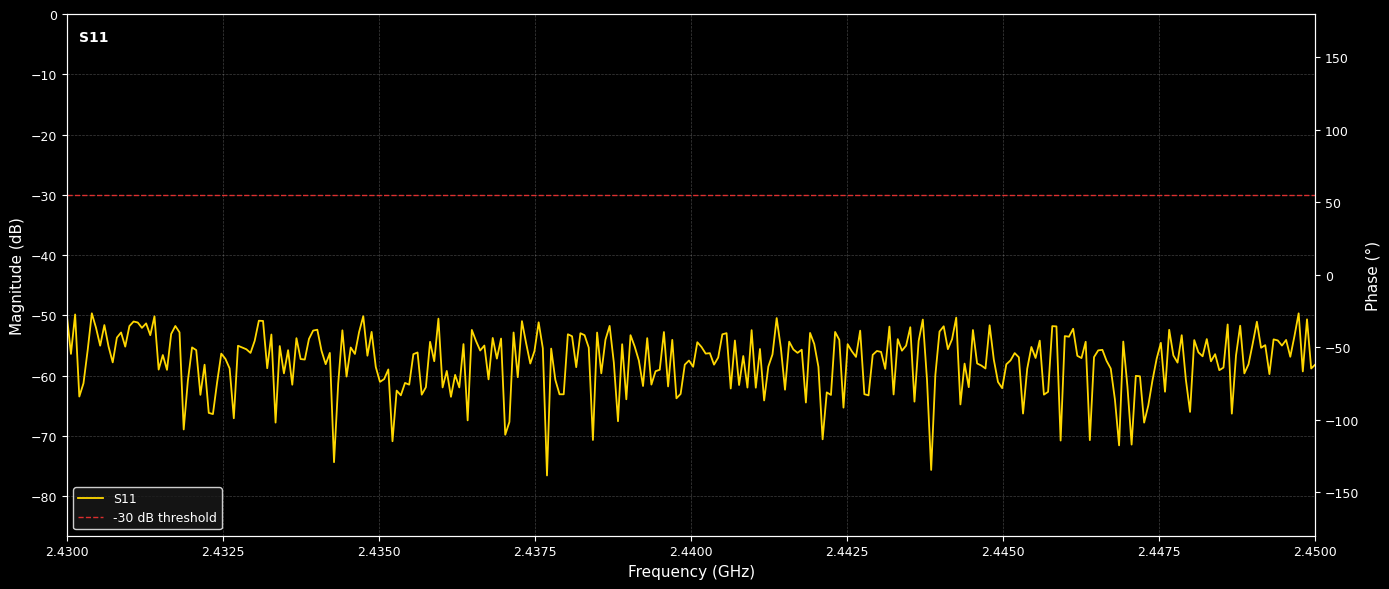

In [4]:
# ---------------------------------------------------------------------------
# Cell 5  --  S11 plot
# ---------------------------------------------------------------------------

# -- unit conversion ---------------------------------------------------------
freq_ghz = np.array(freq_hz, dtype=np.float64) / 1e9
s11_db   = np.array(s11_db,  dtype=np.float64)

# -- style -------------------------------------------------------------------
plt.style.use("dark_background")

TRACE_COLOR   = "#FFD700"   # gold / yellow  --  matches LibreVNA GUI
THRESH_COLOR  = "#FF3333"   # red  --  30 dB pass threshold line
THRESH_DB     = -30.0       # pass criterion boundary

# -- figure ------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(14, 6))
fig.patch.set_facecolor("black")
ax.set_facecolor("black")

# ---- S11 trace -------------------------------------------------------------
ax.plot(freq_ghz, s11_db, color=TRACE_COLOR, linewidth=1.3, label="S11")

# ---- horizontal pass-threshold line ----------------------------------------
ax.axhline(THRESH_DB, color=THRESH_COLOR, linewidth=1.0,
           linestyle="--", alpha=0.85, label="-30 dB threshold")

# ---- axis limits & labels -------------------------------------------------
# Y top fixed at 0 dB (standard S11 reference); bottom auto-fitted to data
# with 10 dB of padding below the deepest measured point.
ax.set_xlim(2.430, 2.450)
ax.set_ylim(bottom=float(s11_db.min()) - 10, top=0)

ax.set_xlabel("Frequency (GHz)", color="white", fontsize=11)
ax.set_ylabel("Magnitude (dB)",  color="white", fontsize=11)
ax.tick_params(colors="white", labelsize=9)

# ---- right-hand Phase axis  (label only -- no trace plotted) ---------------
ax2 = ax.twinx()
ax2.set_ylim(-180, 180)
ax2.set_ylabel("Phase (\u00b0)", color="white", fontsize=11)
ax2.tick_params(colors="white", labelsize=9)
ax2.set_facecolor("black")

# ---- grid ------------------------------------------------------------------
ax.grid(True, which="both", color="white", linestyle="--",
        linewidth=0.5, alpha=0.25)
ax.set_axisbelow(True)

# ---- "S11" corner label ----------------------------------------------------
ax.text(0.01, 0.97, "S11", transform=ax.transAxes,
        color="white", fontsize=10, fontweight="bold",
        verticalalignment="top")

# ---- legend ----------------------------------------------------------------
ax.legend(loc="lower left", fontsize=9,
          facecolor="#1a1a1a", edgecolor="white", labelcolor="white")

plt.tight_layout()
plt.show()

In [5]:
# ---------------------------------------------------------------------------
# Cell 6  --  PASS / FAIL verdict
# ---------------------------------------------------------------------------
# Return loss is defined as the positive quantity RL = -S11(dB).
# The DUT passes when RL > 30 dB at every frequency point, i.e.
# the worst-case (minimum) return loss still exceeds the threshold.
# ---------------------------------------------------------------------------

return_loss      = -np.array(s11_db, dtype=np.float64)   # positive values
min_rl           = float(np.min(return_loss))
worst_idx        = int(np.argmin(return_loss))
worst_freq_ghz   = float(freq_ghz[worst_idx])

THRESHOLD_DB = 30.0   # dB (return-loss scale, positive)

print("=" * 60)
if min_rl > THRESHOLD_DB:
    print(
        f"  PASS  --  Minimum return loss : {min_rl:.2f} dB\n"
        f"            at frequency        : {worst_freq_ghz:.4f} GHz\n"
        f"            threshold           : {THRESHOLD_DB:.0f} dB"
    )
else:
    print(
        f"  FAIL  --  Minimum return loss : {min_rl:.2f} dB\n"
        f"            at frequency        : {worst_freq_ghz:.4f} GHz\n"
        f"            threshold           : {THRESHOLD_DB:.0f} dB"
    )
print("=" * 60)

  PASS  --  Minimum return loss : 49.66 dB
            at frequency        : 2.4304 GHz
            threshold           : 30 dB
